In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# url = 'https://en.wikipedia.org/wiki/FTSE_100_Index'
# tables = pd.read_html(url)

# ftse100_df = tables[6]
# tickers = ftse100_df['Ticker'].tolist()
# tickers = [ticker + '.L' for ticker in tickers]  # Yahoo Finance suffix for London Stock Exchange

In [4]:
import pandas as pd
import requests

url = 'https://en.wikipedia.org/wiki/FTSE_100_Index'

# Define a User-Agent header to mimic a web browser
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.60 Safari/537.36'
}

# Make the request with the headers
try:
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # This will raise an HTTPError for bad responses (4xx or 5xx)
    
    # Pass the content of the response to pandas
    tables = pd.read_html(response.text)
    
    ftse100_df = tables[6]
    tickers = ftse100_df['Ticker'].tolist()
    tickers = [ticker + '.L' for ticker in tickers]  # Yahoo Finance suffix for London Stock Exchange

    print(f"Number of tickers found: {len(tickers)}")

except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")

Number of tickers found: 100


In [5]:
# Fetch historical data (e.g., 5 years of daily data)
data = yf.download(tickers, start="2020-01-01", end="2024-12-31", group_by='ticker')

[*********************100%***********************]  100 of 100 completed


In [6]:
data.head()

Ticker          STAN.L                                               \
Price             Open        High         Low       Close   Volume   
Date                                                                  
2020-01-02  711.336178  722.918831  709.938245  718.924805  3154461   
2020-01-03  712.135127  719.723755  708.540466  719.723755  3515315   
2020-01-06  710.936809  711.336236  697.357141  705.944275  4954038   
2020-01-07  706.543348  708.340708  697.556787  700.552307  4293766   
2020-01-08  694.161931  699.753544  685.974163  697.756531  4025235   

Ticker           SHEL.L                                                  ...  \
Price              Open         High          Low        Close   Volume  ...   
Date                                                                     ...   
2020-01-02  2231.186917  2262.612085  2228.256882  2251.139404  4710773  ...   
2020-01-03  2269.096808  2298.107805  2265.605123  2293.039795  4984931  ...   
2020-01-06  2312.493758  2333.034935  2302.018700  2303.515137  7332363  ...   
2020-01-07  2312.991829  2314.069341  2281.067853  2285.058350  5726726  ...   
2020-01-08  2295.533906  2296.531531  2261.115862  2270.094482  7149697  ...   

Ticker           RTO.L                                               \
Price             Open        High         Low       Close   Volume   
Date                                                                  
2020-01-02  453.703550  458.299540  452.904230  455.202240  1981730   
2020-01-03  451.905067  458.699148  449.307361  457.500183  1768294   
2020-01-06  451.905051  459.380543  448.707864  452.104889  2304051   
2020-01-07  444.811307  447.658794  433.321347  442.013733  7707219   
2020-01-08  440.914678  446.010231  437.118008  445.111023  3683135   

Ticker           BAB.L                                               
Price             Open        High         Low       Close   Volume  
Date                                                                 
2020-01-02  624.082578  637.080132  623.682629  630.881287   885762  
2020-01-03  624.682535  628.081920  612.284903  612.884766   989205  
2020-01-06  615.884168  632.281108  608.485535  628.281860  1422477  
2020-01-07  633.081010  646.678429  631.721280  646.478455  1630913  
2020-01-08  634.880523  649.677727  634.880523  640.879395  1619818  

[5 rows x 500 columns]

In [7]:
# Step 1: Calculate Mid prices for each ticker
mid_prices = pd.concat([
    ((data[ticker]['Open'] + data[ticker]['Close']) / 2).rename(ticker)
    for ticker in tickers
], axis=1)

# Step 2: Drop rows with missing values (optional)
mid_prices = mid_prices.dropna()

In [8]:
mid_prices.head()

III.L        ADM.L       AAF.L       ALW.L        AAL.L  \
Date                                                                        
2022-07-18  1193.616181  1770.288384  158.555075  930.801977  2574.944447   
2022-07-19  1189.618954  1732.080525  162.050759  929.303080  2552.169888   
2022-07-20  1200.361113  1734.577802  163.998371  942.793089  2583.270179   
2022-07-21  1223.593920  1744.566886  165.945963  952.785450  2563.435167   
2022-07-22  1244.578427  1741.819970  165.496529  953.285163  2591.841269   

                 ANTO.L        AHT.L        ABF.L         AZN.L      AUTO.L  \
Date                                                                          
2022-07-18  1028.609801  3871.104797  1611.763737  11140.143039  584.318319   
2022-07-19  1029.858952  3887.594510  1639.992147  11113.163181  586.617272   
2022-07-20  1053.344302  4023.010463  1673.716167  11072.192487  597.711911   
2022-07-21  1043.350499  4103.460385  1692.451994  10782.397350  609.006414   
2022-07-22  1064.087686  4159.926055  1692.951516  10762.411244  613.304384   

            ...        STJ.L        TW.L      TSCO.L       ULVR.L  \
Date        ...                                                     
2022-07-18  ...  1151.496889  118.416243  259.682190  3875.865826   
2022-07-19  ...  1154.743272  119.438792  260.281512  3891.598508   
2022-07-20  ...  1164.982076  121.334243  261.230283  3911.575085   
2022-07-21  ...  1171.225381  124.177429  260.081712  3888.601438   
2022-07-22  ...  1182.712879  125.474325  259.832030  3906.580887   

                   UU.L        UTG.L       VOD.L       WEIR.L        WTB.L  \
Date                                                                         
2022-07-18  1026.843683  1151.705643  129.199156  1385.705290  2643.169258   
2022-07-19  1044.818920  1155.201826  130.067017  1392.201611  2647.665252   
2022-07-20  1051.060426  1166.189358  130.096934  1414.438790  2689.628375   
2022-07-21  1057.301782  1170.184643  128.690449  1465.159878  2679.137616   
2022-07-22  1066.788897  1196.655002  128.750265  1492.144176  2674.142020   

                 WPP.L  
Date                    
2022-07-18  805.614230  
2022-07-19  820.790069  
2022-07-20  851.041690  
2022-07-21  863.821386  
2022-07-22  864.919639  

[5 rows x 100 columns]

In [9]:
# Step 3: Transpose so that each row is a ticker and columns are dates
data_for_clustering = mid_prices.T.copy()

data_for_clustering.head()

Date    2022-07-18   2022-07-19   2022-07-20   2022-07-21   2022-07-22  \
III.L  1193.616181  1189.618954  1200.361113  1223.593920  1244.578427   
ADM.L  1770.288384  1732.080525  1734.577802  1744.566886  1741.819970   
AAF.L   158.555075   162.050759   163.998371   165.945963   165.496529   
ALW.L   930.801977   929.303080   942.793089   952.785450   953.285163   
AAL.L  2574.944447  2552.169888  2583.270179  2563.435167  2591.841269   

Date    2022-07-25   2022-07-26   2022-07-27   2022-07-28   2022-07-29  ...  \
III.L  1227.091179  1213.601346  1214.100990  1239.332501  1262.315172  ...   
ADM.L  1733.329264  1759.050816  1803.501677  1858.190961  1901.393003  ...   
AAF.L   166.445365   170.340574   171.489160   165.446595   158.405252  ...   
ALW.L   957.282108   942.293457   945.790682   961.279134   970.772059  ...   
AAL.L  2634.695702  2698.610025  2703.507483  2785.298757  2861.947093  ...   

Date    2024-12-10   2024-12-12   2024-12-13   2024-12-18   2024-12-19  \
III.L  3634.626814  3632.127043  3639.126400  3640.626273  3564.634047   
ADM.L  2669.768238  2646.774687  2639.776439  2611.784197  2603.786295   
AAF.L   106.382556   106.132595   106.982454   106.332565   104.882798   
ALW.L  1278.785721  1278.785721  1280.785357  1252.790053  1242.791672   
AAL.L  2454.477706  2491.503322  2441.236821  2378.465032  2311.524568   

Date    2024-12-20   2024-12-23   2024-12-24   2024-12-27   2024-12-30  
III.L  3537.636769  3540.136601  3575.633081  3596.130808  3580.132620  
ADM.L  2595.788467  2605.286032  2625.780321  2619.782030  2614.283596  
AAF.L   104.682834   107.232414   110.381901   112.481552   113.381405  
ALW.L  1246.791121  1249.790467  1251.790314  1241.791964  1244.791370  
AAL.L  2285.778301  2286.759206  2314.957531  2298.529124  2287.249729  

[5 rows x 613 columns]

In [10]:
# Calculate percentage difference with respect to the first column (first date)
df_pct_diff = ((data_for_clustering.T - data_for_clustering.T.iloc[0]) / data_for_clustering.T.iloc[0]) * 100

# Transpose back to original format: Tickers as rows, Dates as columns
df_pct_diff = df_pct_diff.T

# Optional: round values for better readability
df_pct_diff = df_pct_diff.round(2)


In [11]:
df_pct_diff.head()

Date   2022-07-18  2022-07-19  2022-07-20  2022-07-21  2022-07-22  2022-07-25  \
III.L         0.0       -0.33        0.57        2.51        4.27        2.80   
ADM.L         0.0       -2.16       -2.02       -1.45       -1.61       -2.09   
AAF.L         0.0        2.20        3.43        4.66        4.38        4.98   
ALW.L         0.0       -0.16        1.29        2.36        2.42        2.84   
AAL.L         0.0       -0.88        0.32       -0.45        0.66        2.32   

Date   2022-07-26  2022-07-27  2022-07-28  2022-07-29  ...  2024-12-10  \
III.L        1.67        1.72        3.83        5.76  ...      204.51   
ADM.L       -0.63        1.88        4.97        7.41  ...       50.81   
AAF.L        7.43        8.16        4.35       -0.09  ...      -32.90   
ALW.L        1.23        1.61        3.27        4.29  ...       37.39   
AAL.L        4.80        4.99        8.17       11.15  ...       -4.68   

Date   2024-12-12  2024-12-13  2024-12-18  2024-12-19  2024-12-20  2024-12-23  \
III.L      204.30      204.88      205.01      198.64      196.38      196.59   
ADM.L       49.51       49.12       47.53       47.08       46.63       47.17   
AAF.L      -33.06      -32.53      -32.94      -33.85      -33.98      -32.37   
ALW.L       37.39       37.60       34.59       33.52       33.95       34.27   
AAL.L       -3.24       -5.19       -7.63      -10.23      -11.23      -11.19   

Date   2024-12-24  2024-12-27  2024-12-30  
III.L      199.56      201.28      199.94  
ADM.L       48.33       47.99       47.68  
AAF.L      -30.38      -29.06      -28.49  
ALW.L       34.49       33.41       33.73  
AAL.L      -10.10      -10.73      -11.17  

[5 rows x 613 columns]

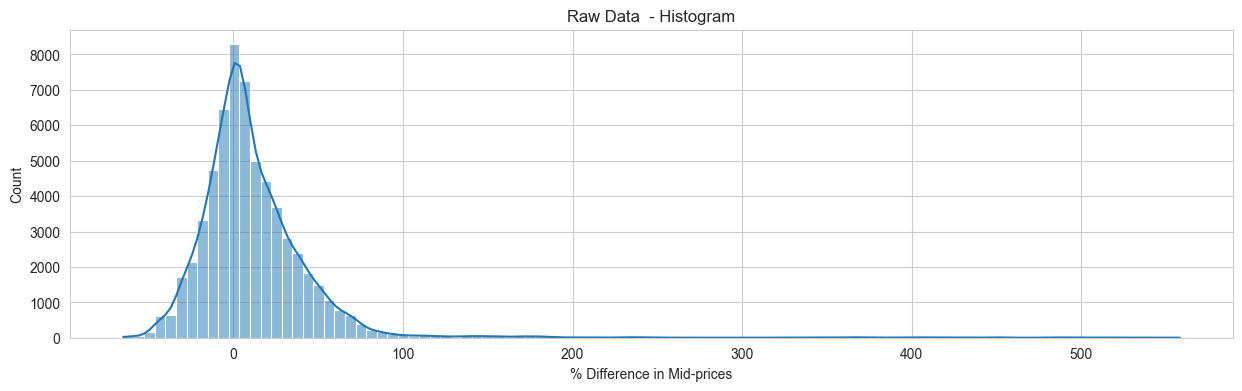

In [12]:
plt.figure(figsize=(15, 4))
sns.histplot(df_pct_diff.values.flatten(), bins=100, kde=True)
plt.title(f'{"Raw Data"}  - Histogram')
plt.xlabel("% Difference in Mid-prices")
plt.show()

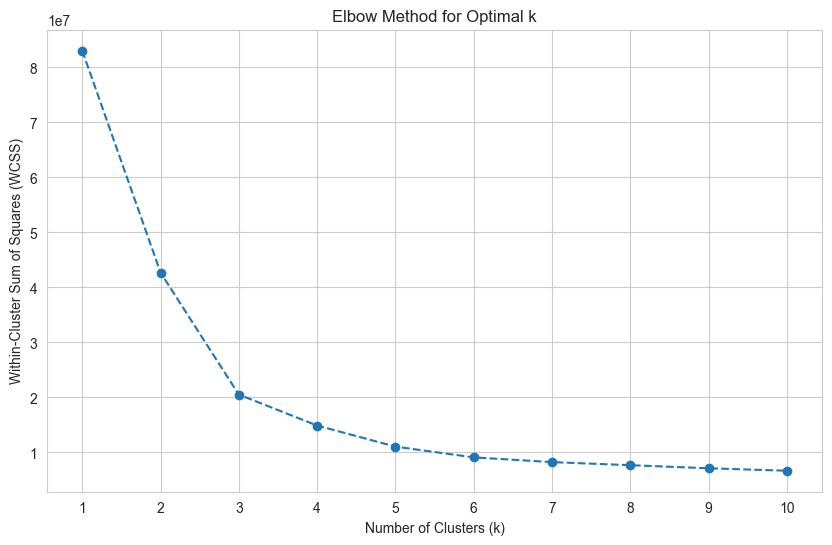

In [13]:
# Implement the Elbow Method
wcss = []  # Within-cluster sum of squares
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_pct_diff)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_range)
plt.grid(True)

In [43]:
# Step 4: Clustering Algorithms
from sklearn.cluster import Birch

# Choose optimal k based on the elbow (assume 4 here)
optimal_k = 4

# Fit clustering models
kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(df_pct_diff)
gmm = GaussianMixture(n_components=optimal_k, random_state=42).fit(df_pct_diff)
dbscan = DBSCAN(eps=2.5, min_samples=3).fit(df_pct_diff)
agglo = AgglomerativeClustering(n_clusters=optimal_k).fit(df_pct_diff)
birch = Birch(n_clusters=optimal_k).fit(df_pct_diff)

# Step 5: Evaluation Metrics
def evaluate_clustering(data, labels, name):
    if len(set(labels)) <= 1:
        print(f"{name} clustering resulted in 1 or fewer clusters. Skipping metrics.\n")
        return
    print(f"Results for {name}:")
    print(f"Silhouette Score (Higher is better): {silhouette_score(data, labels):.3f}")
    print(f"Davies-Bouldin Index (Lower is better): {davies_bouldin_score(data, labels):.3f}")
    print(f"Calinski-Harabasz Score (Higher is better): {calinski_harabasz_score(data, labels):.3f}\n")

evaluate_clustering(df_pct_diff, kmeans.labels_, "KMeans")
evaluate_clustering(df_pct_diff, gmm.predict(df_pct_diff), "GMM")
evaluate_clustering(df_pct_diff, dbscan.labels_, "DBSCAN")
evaluate_clustering(df_pct_diff, agglo.labels_, "Agglomerative")
evaluate_clustering(df_pct_diff, birch.labels_, "Birch")

# Step 6: Visualize stock trends by cluster
def plot_clusters_trend(df, labels, title_prefix):
    df_copy = df.copy()
    df_copy['Cluster'] = labels
    for cluster_id in sorted(df_copy['Cluster'].unique()):
        cluster_members = df_copy[df_copy['Cluster'] == cluster_id].drop(columns='Cluster')
        plt.figure(figsize=(14, 5))
        for i in range(len(cluster_members)):
            plt.plot(cluster_members.columns, cluster_members.iloc[i], alpha=0.4)
        plt.title(f"{title_prefix} - Cluster {cluster_id} Trends")
        plt.xticks(rotation=45)
        plt.xlabel('Date')
        plt.tight_layout()
        plt.show()


Results for KMeans:
Silhouette Score (Higher is better): 0.323
Davies-Bouldin Index (Lower is better): 0.774
Calinski-Harabasz Score (Higher is better): 146.063

Results for GMM:
Silhouette Score (Higher is better): 0.323
Davies-Bouldin Index (Lower is better): 0.774
Calinski-Harabasz Score (Higher is better): 146.063

DBSCAN clustering resulted in 1 or fewer clusters. Skipping metrics.

Results for Agglomerative:
Silhouette Score (Higher is better): 0.305
Davies-Bouldin Index (Lower is better): 0.804
Calinski-Harabasz Score (Higher is better): 141.693

Results for Birch:
Silhouette Score (Higher is better): 0.305
Davies-Bouldin Index (Lower is better): 0.804
Calinski-Harabasz Score (Higher is better): 141.693



# KMeans

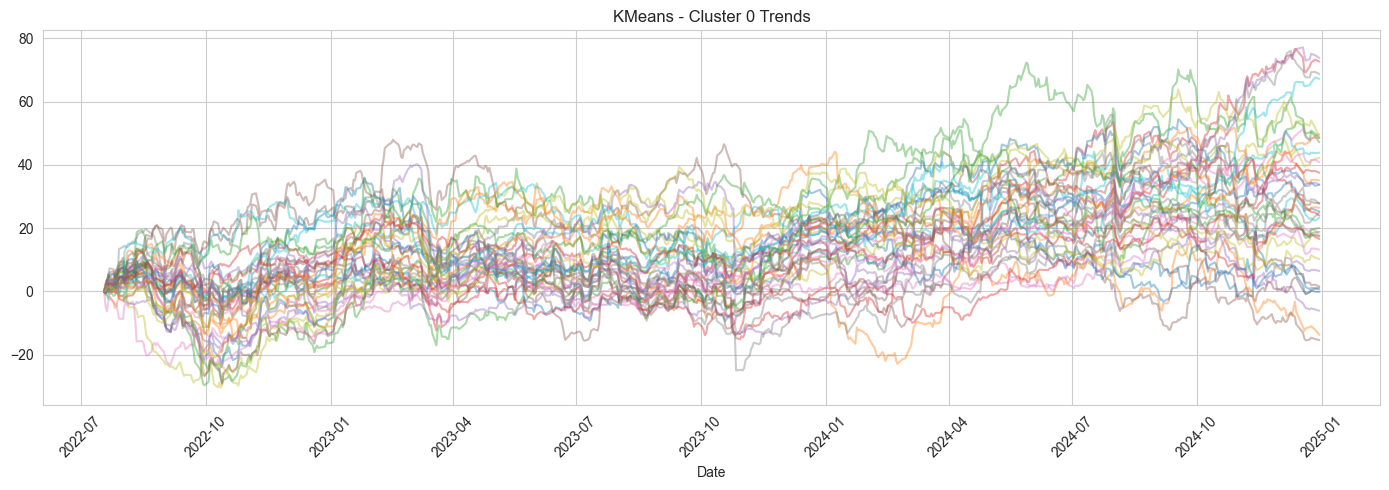

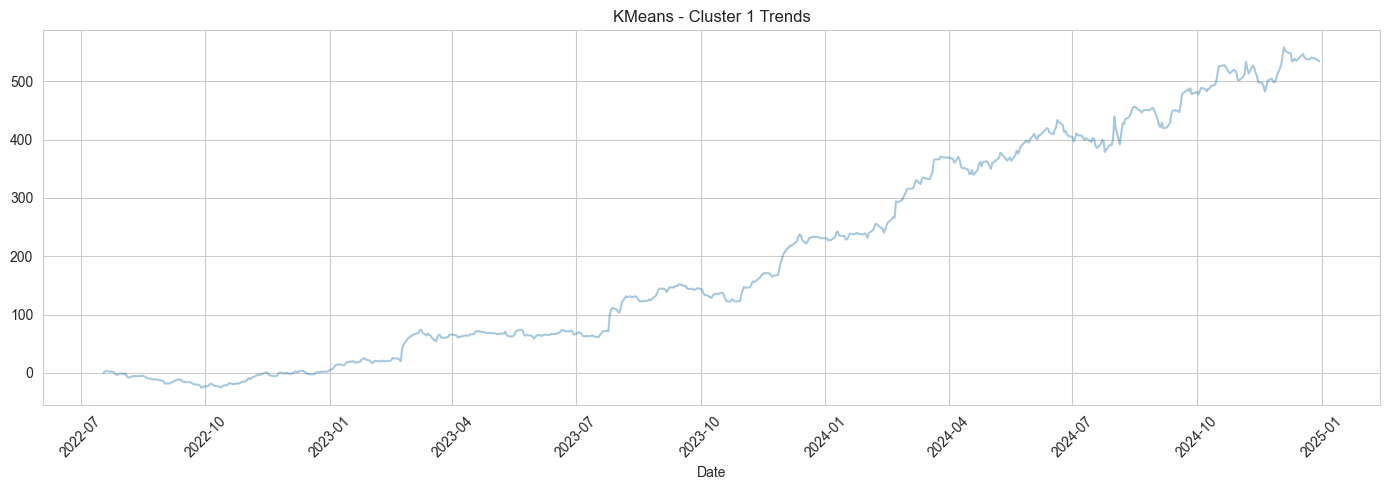

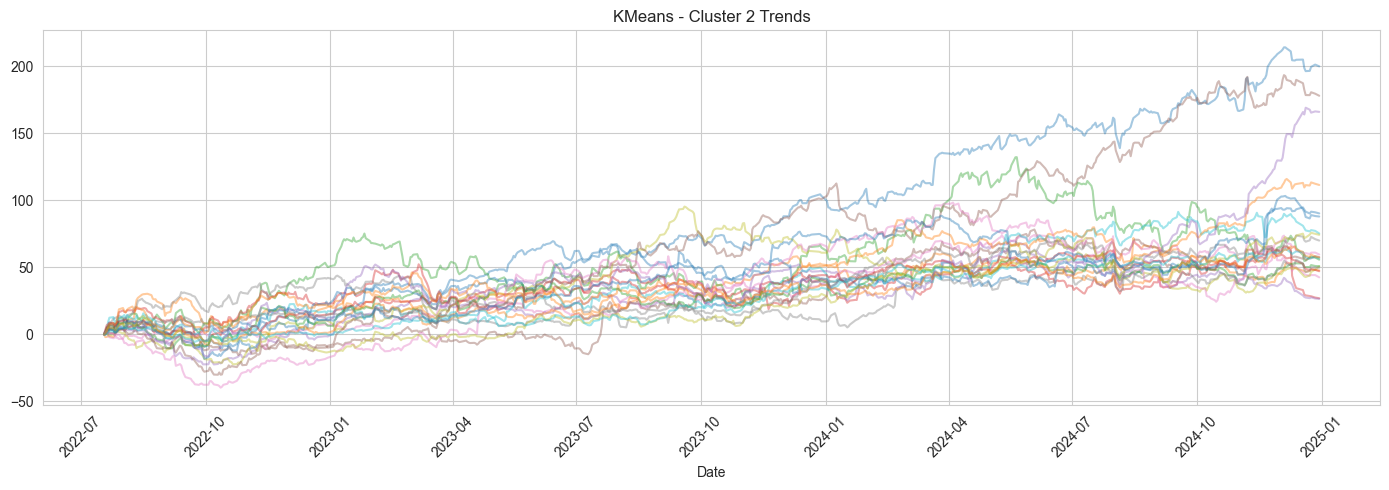

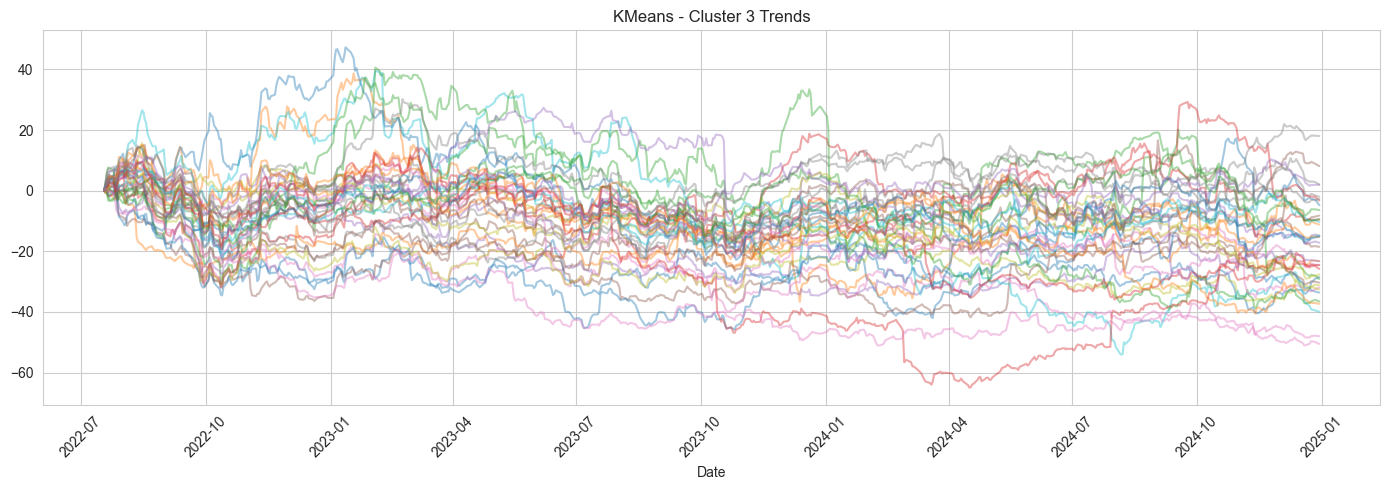

In [44]:
# Example: Visualize KMeans clusters
plot_clusters_trend(df_pct_diff, kmeans.labels_, "KMeans")

# Agglo

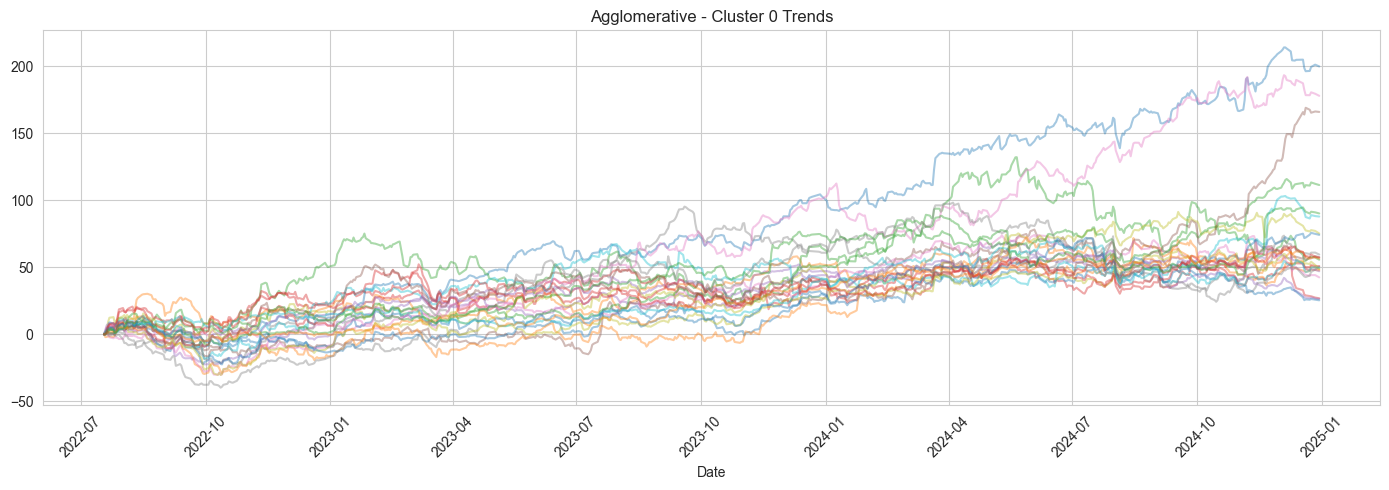

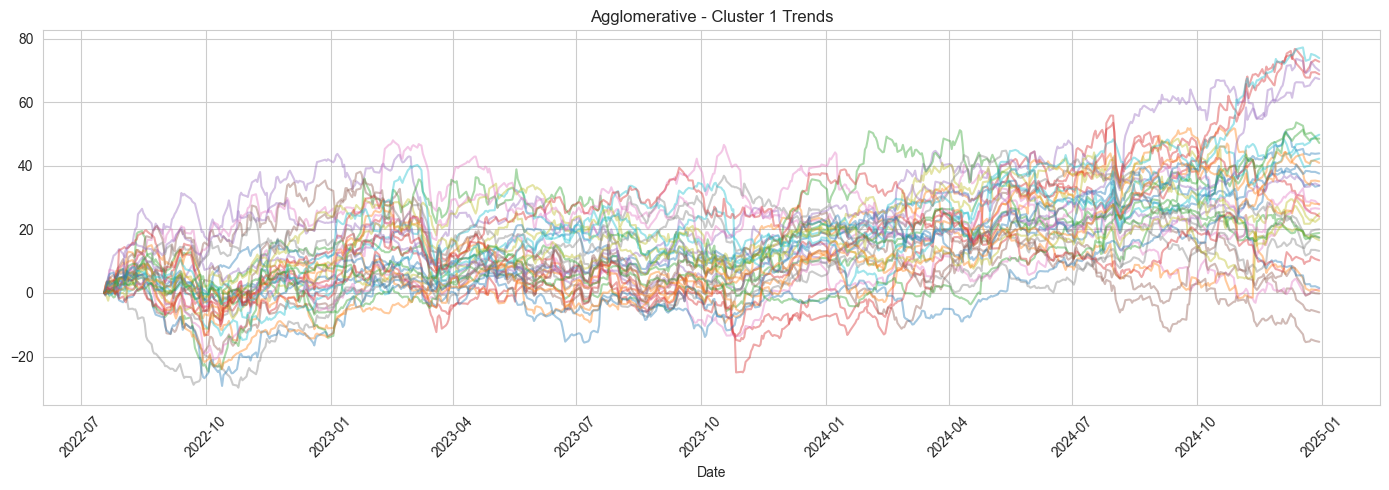

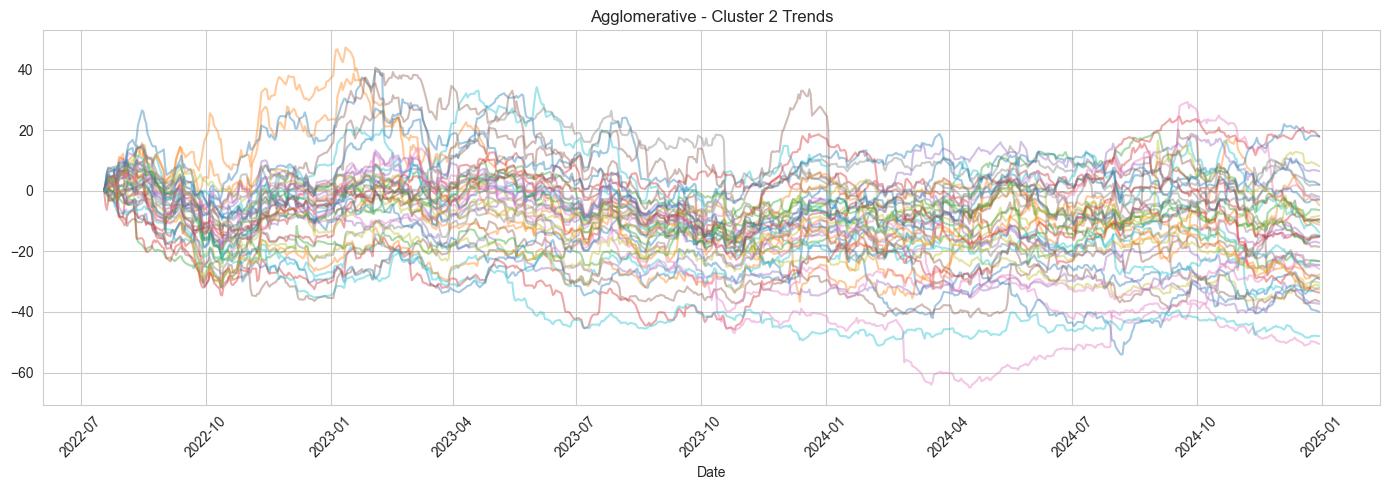

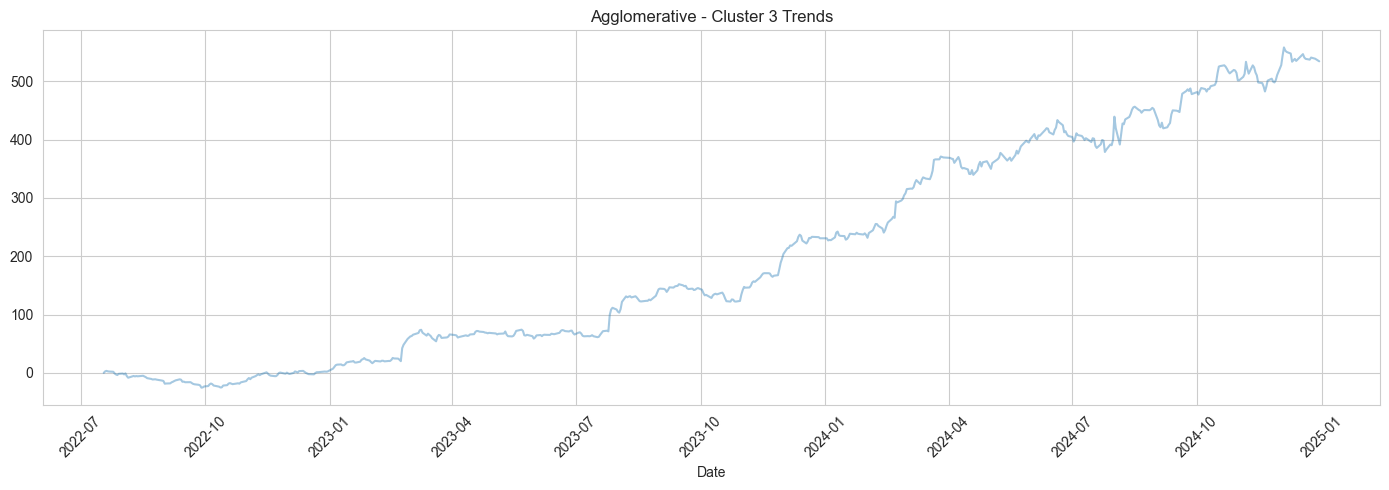

In [45]:
# Example: Visualize KMeans clusters
plot_clusters_trend(df_pct_diff, agglo.labels_, "Agglomerative")

# GMM

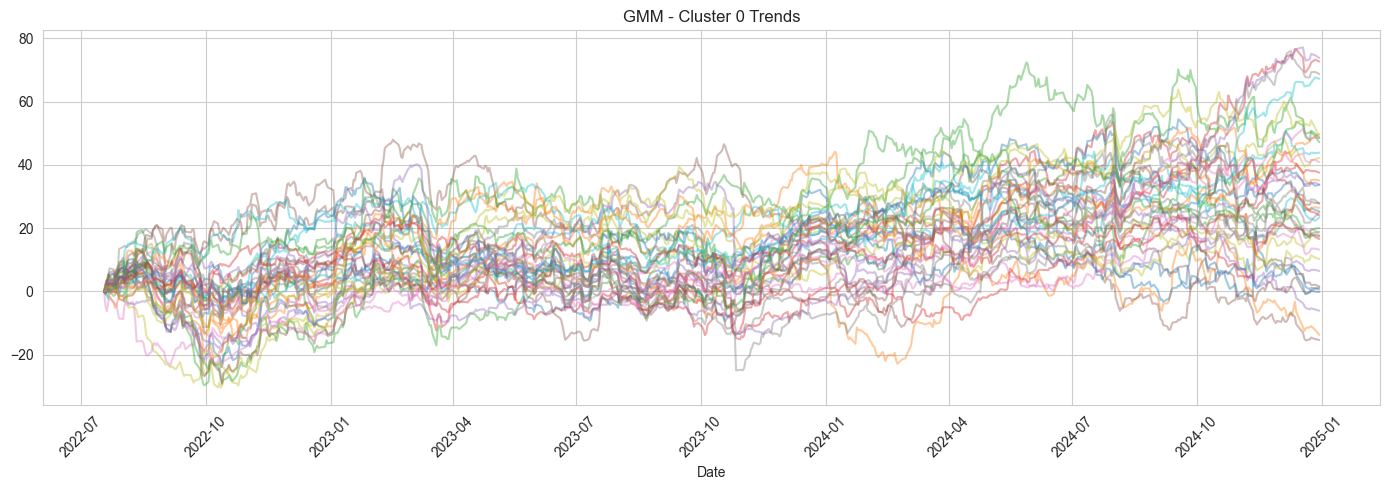

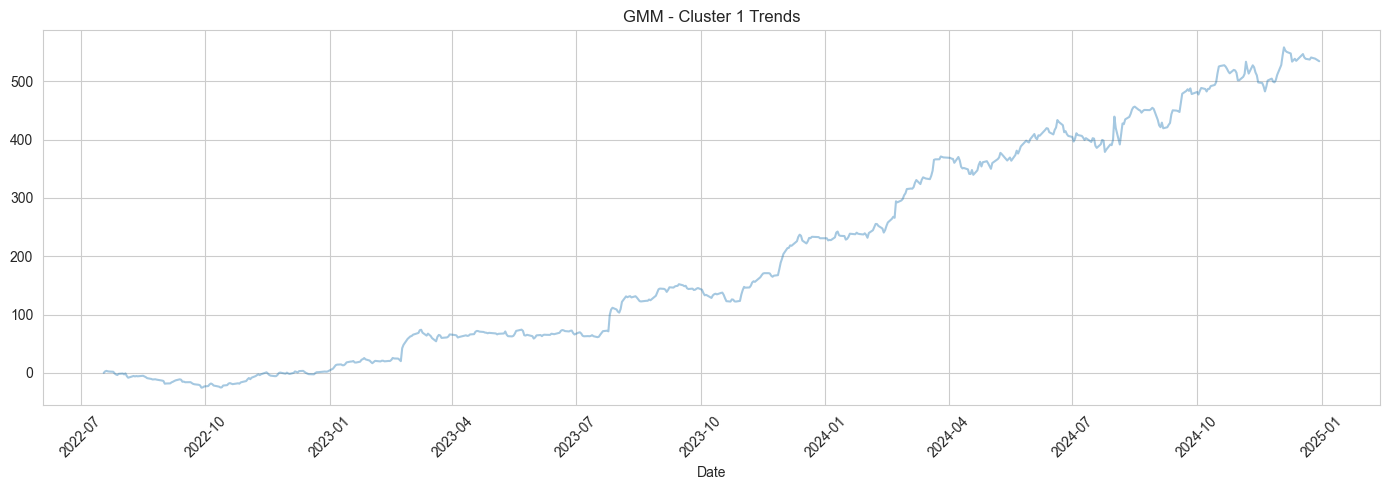

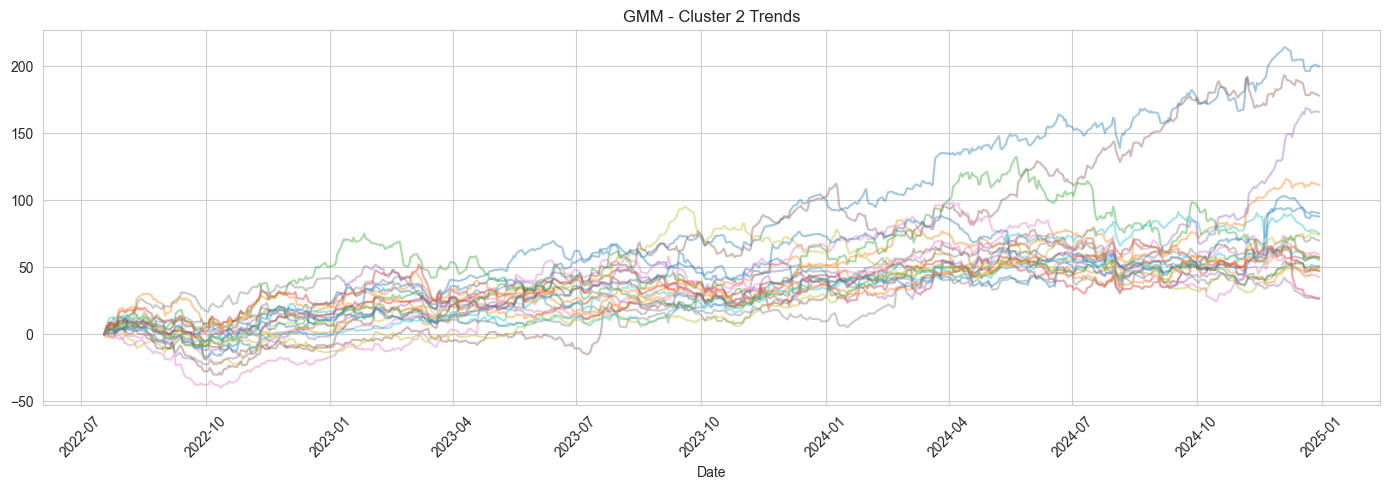

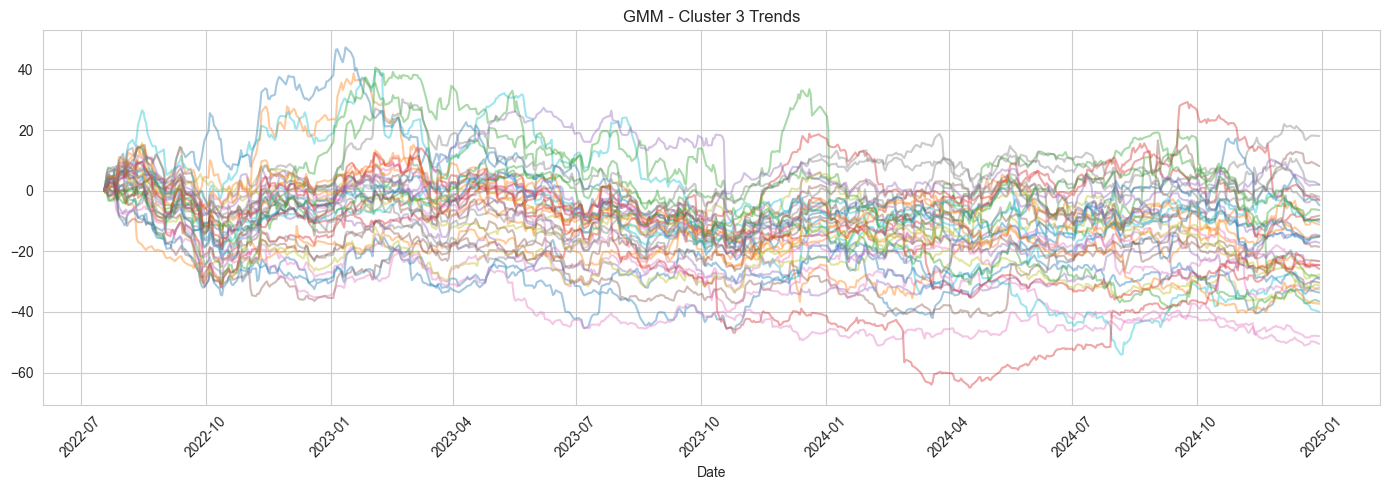

In [46]:
# Example: Visualize KMeans clusters
plot_clusters_trend(df_pct_diff, gmm.predict(df_pct_diff), "GMM")

# Birch

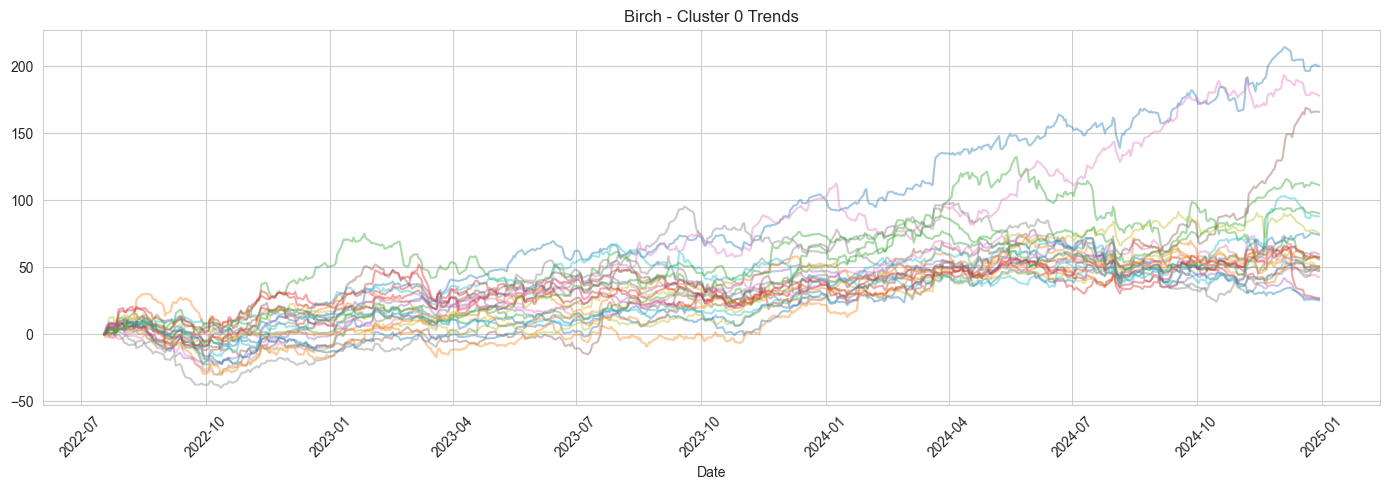

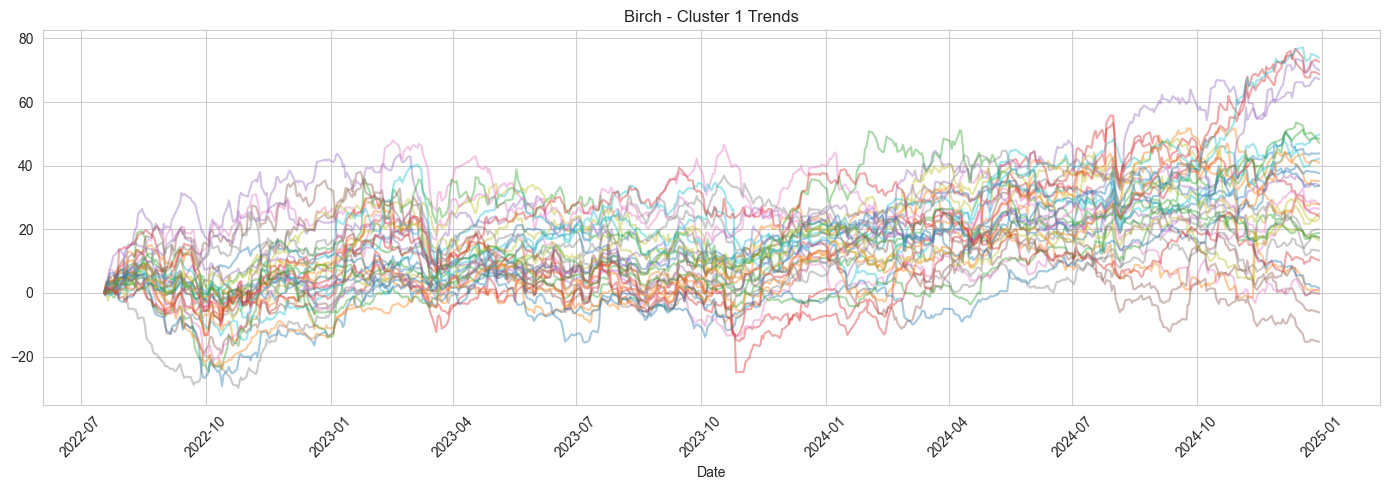

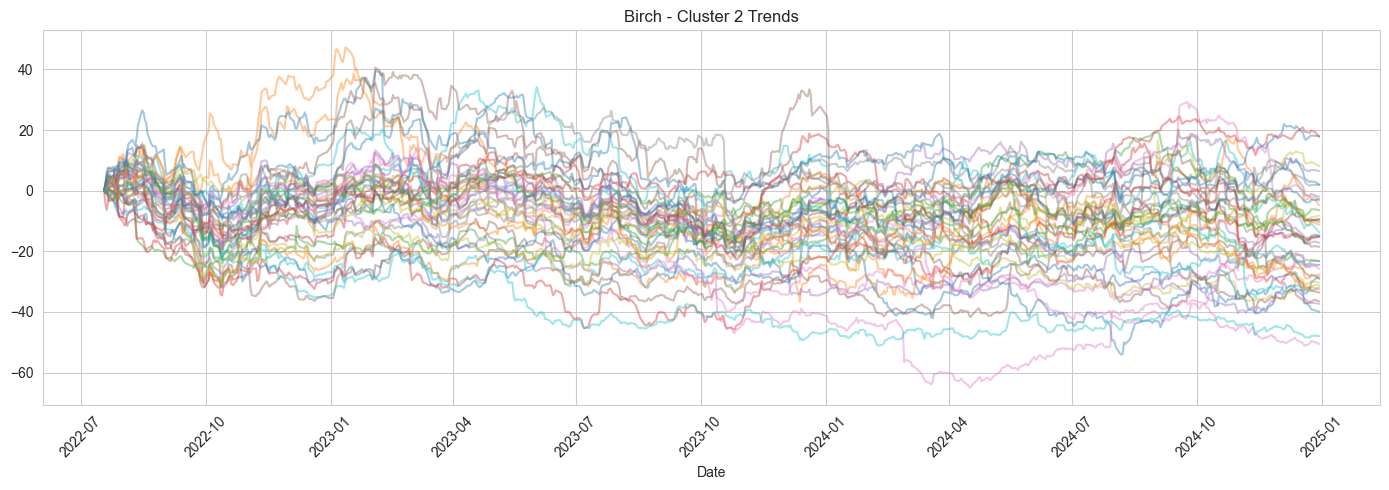

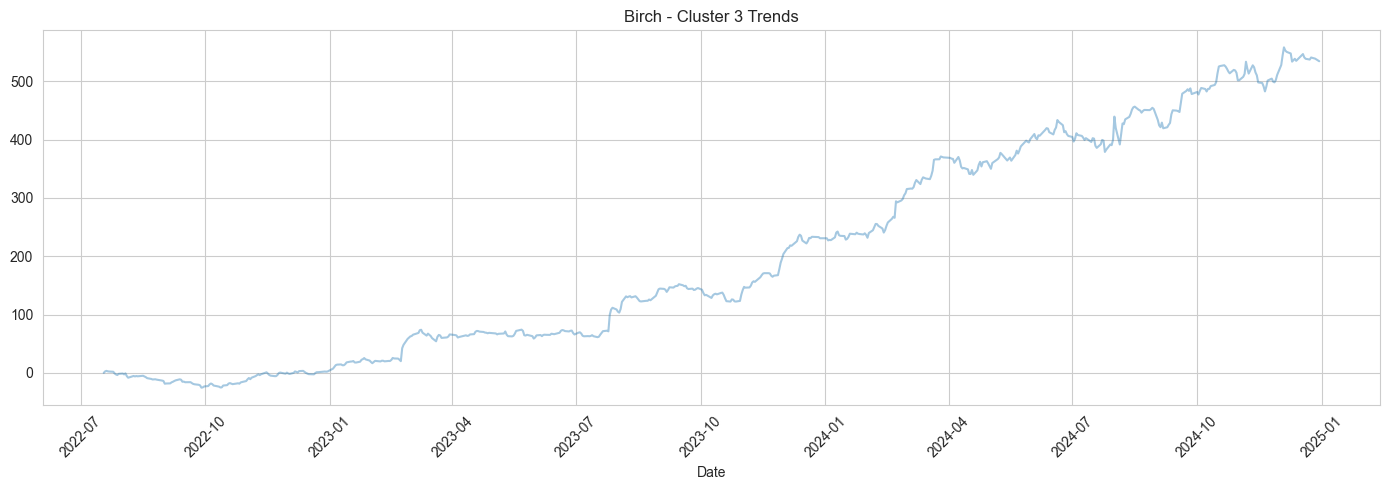

In [47]:
# Example: Visualize KMeans clusters
plot_clusters_trend(df_pct_diff, birch.labels_, "Birch")

# Cluster Visualization

In [48]:
from sklearn.manifold import TSNE
import umap.umap_ as umap

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df_pct_diff)

umap_model = umap.UMAP(random_state=42)
X_umap = umap_model.fit_transform(df_pct_diff)

def plot_clusters_2D(X_proj, labels, method_name, reduction="t-SNE"):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_proj[:, 0], y=X_proj[:, 1], hue=labels, palette='tab10', s=30)
    plt.title(f'{method_name} Clusters Visualized with {reduction}')
    plt.grid(True)
    plt.show()

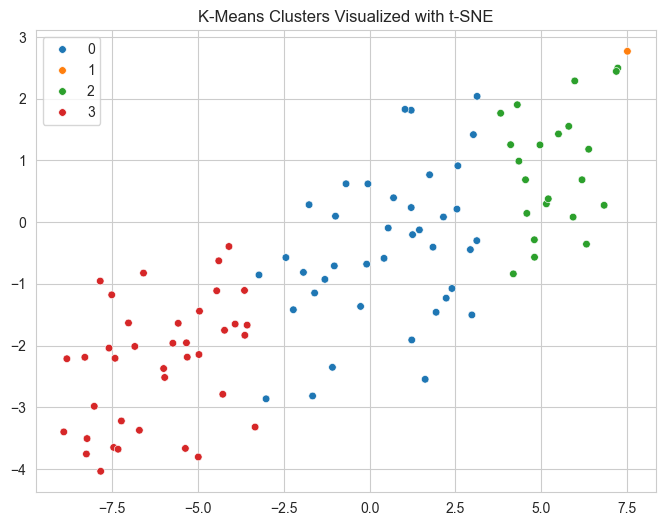

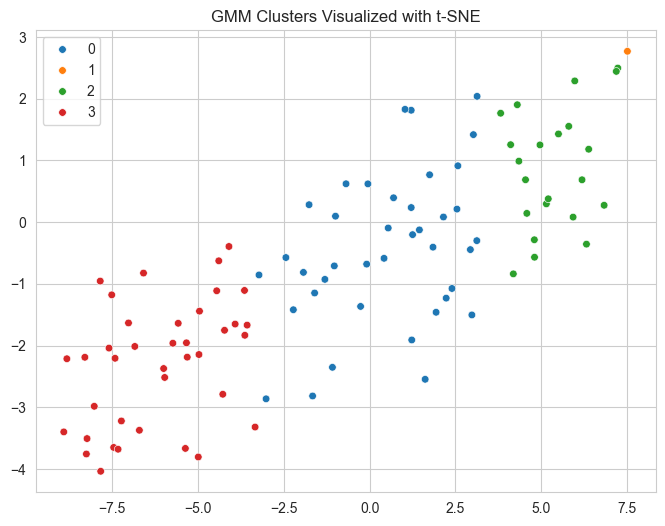

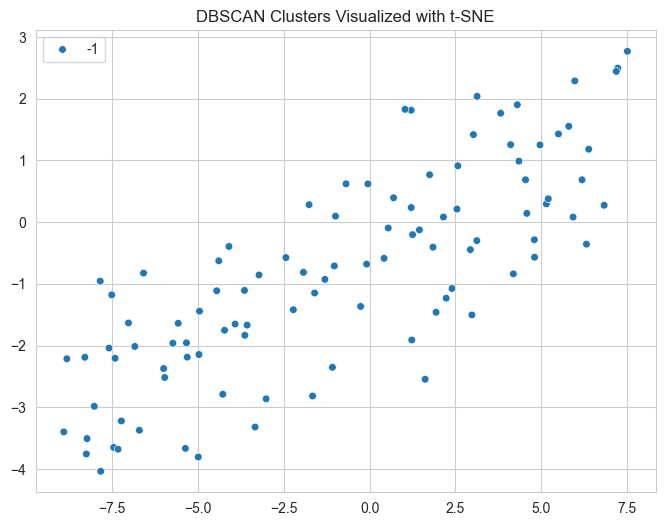

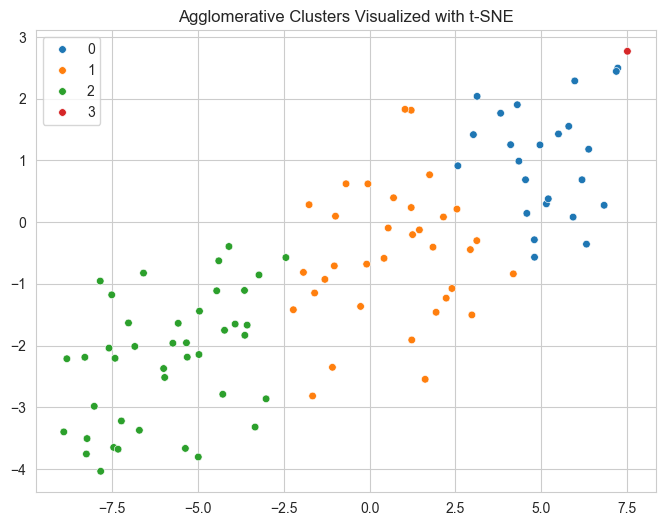

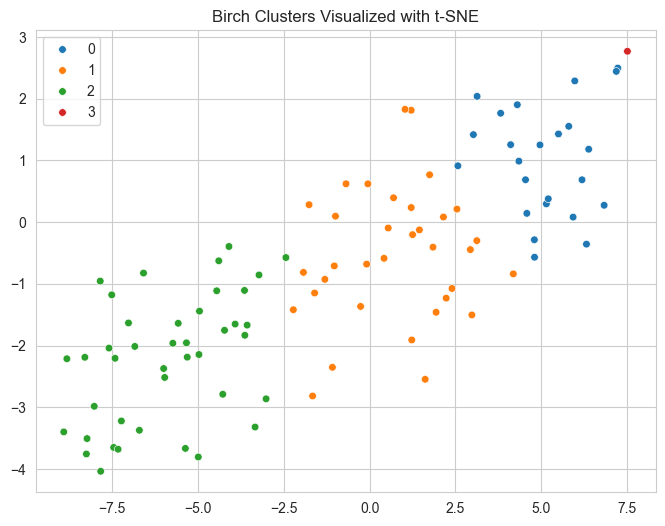

In [49]:
plot_clusters_2D(X_tsne, kmeans.labels_, "K-Means", "t-SNE")
plot_clusters_2D(X_tsne, gmm.predict(df_pct_diff), "GMM", "t-SNE")
plot_clusters_2D(X_tsne, dbscan.labels_, "DBSCAN", "t-SNE")
plot_clusters_2D(X_tsne, agglo.labels_, "Agglomerative", "t-SNE")
plot_clusters_2D(X_tsne, birch.labels_, "Birch", "t-SNE")

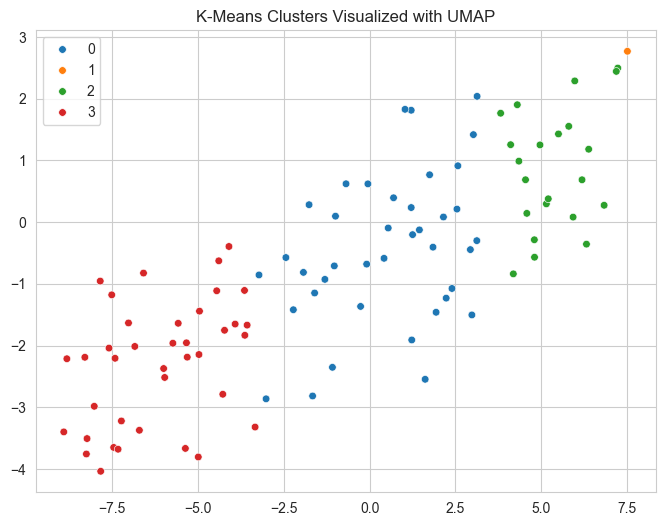

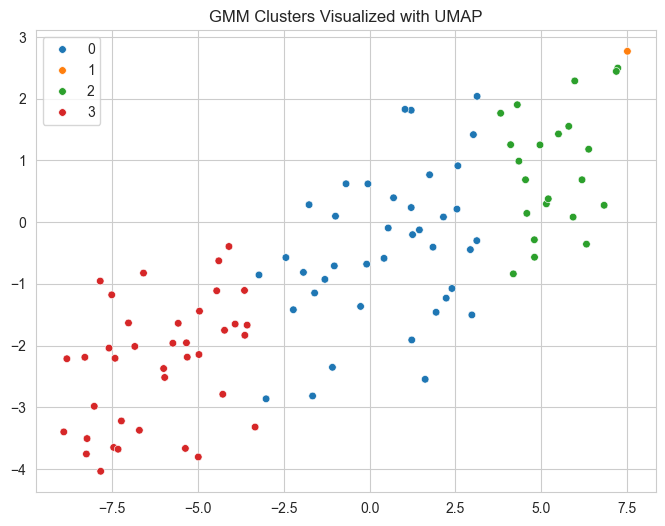

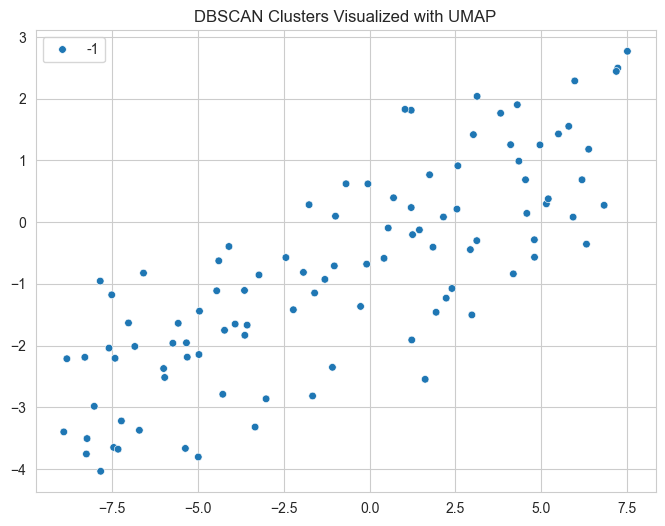

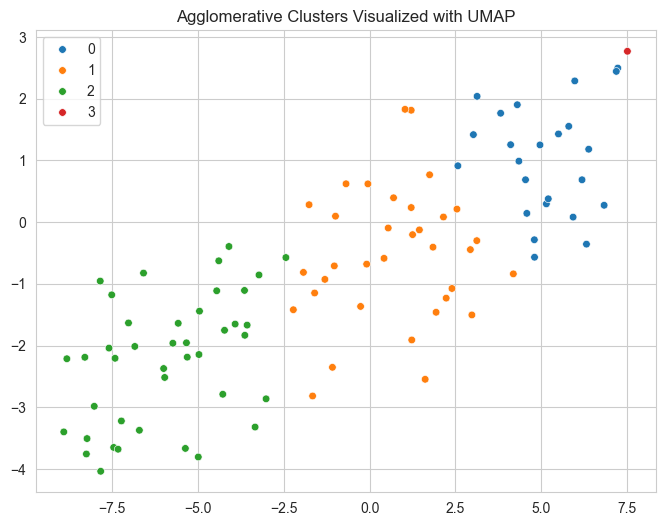

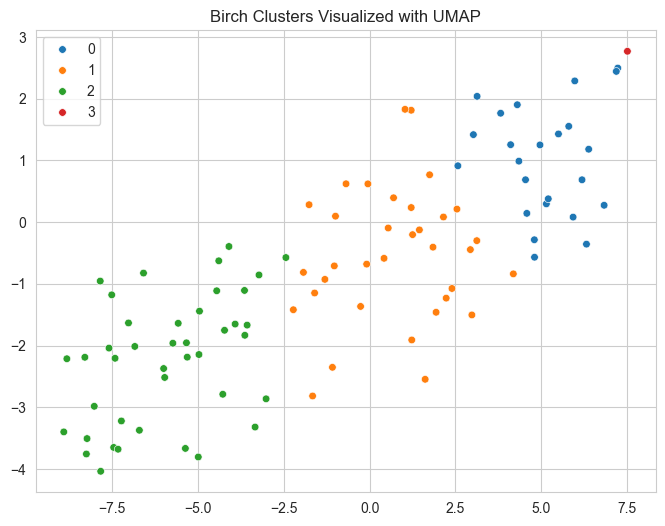

In [50]:
plot_clusters_2D(X_tsne, kmeans.labels_, "K-Means", "UMAP")
plot_clusters_2D(X_tsne, gmm.predict(df_pct_diff), "GMM", "UMAP")
plot_clusters_2D(X_tsne, dbscan.labels_, "DBSCAN", "UMAP")
plot_clusters_2D(X_tsne, agglo.labels_, "Agglomerative", "UMAP")
plot_clusters_2D(X_tsne, birch.labels_, "Birch", "UMAP")